In [ ]:
## Checking that we're connected to a GPU runtime
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jul 13 14:18:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    36W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Extract zip file (Only needs to be run once)
import shutil
import os
filename = "/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM/images-annotated.tar.gz"
extract_dir = "/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM/images-annotated"
if(len(os.listdir(extract_dir))==0):
  shutil.unpack_archive(filename, extract_dir)
else:
  print(f"Files already in the images-annotated folder: {os.listdir(extract_dir)}")

Files already in the images-annotated folder: ['images-annotated']
['content' 'emotion' 'media']


In [ ]:
#%ls "/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/HipsterWars"
%ls "/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM/images-annotated/images-annotated/0000"

1220000.jpg  28710000.jpg  28820000.jpg


In [ ]:
# Get models for predicting emotion and media from images

import tensorflow as tf

class Predictor:
  def __init__(self,model_dir):
    self.model_dir = model_dir
    self.model = tf.keras.models.load_model(model_dir)
    p_start = model_dir.rfind("/")+1
    self.model_name = model_dir[p_start:]
    return

def get_models():
  emote = Predictor("/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM/models/2022-07-13/prototype-emotion-1")
  media = Predictor("/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM/models/2022-07-13/prototype-media-1")
  return emote,media

#predictor_emote,predictor_media = get_models()

In [ ]:
## Predict the hipsterwars data using the BAM emotion/media predictors
import os
from copy import deepcopy as dc
import pandas as pd
hipsterdirroot = "/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/HipsterWars/images"

# Get prediction for emotion types
def predict_emotion(imgtens,predictor):
  hipster_emote_preds = predictor.model.predict(imgtens)
  return pd.DataFrame(data=hipster_emote_preds,columns=["prob_peaceful","prob_happy","prob_gloomy","prob_scary"])


# Get predictions for media types
def predict_media(imgtens,predictor):
  hipster_media_preds = predictor.model.predict(imgtens)
  return pd.DataFrame(data=hipster_media_preds,columns=["prob_pen","prob_oilpaint","prob_watercolor","prob_comic","prob_graphite","prob_vectorart","prob_3d"])

def predict_features(imgdirs,
                     emote_predictor = Predictor("/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM/models/2022-07-13/prototype-emotion-1"),
                     media_predictor = Predictor("/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM/models/2022-07-13/prototype-media-1"),
                     emote_save_dir = False,
                     media_save_dir = False):
  # Convert the image directories to tensors
  tens = dirs_to_tensors(imgdirs)
  # Predict this list of tensors
  emote_pred = predict_emotion(tens,emote_predictor)
  media_pred = predict_media(tens,media_predictor)
  # Delete the initial tensors
  del tens
  # Save the dataframe if appropriate
  if(type(emote_save_dir)==str):
    with open(emote_save_dir,"w") as f:
      emote_pred.to_csv(f,index=False,line_terminator="\n")
  if(type(media_save_dir)==str):
    with open(media_save_dir,"w") as f:
      media_pred.to_csv(f,index=False,line_terminator="\n")
  # Convert the predictions to single 11-column tensors
  tens = []
  for ind in emote_pred.index:
    tens.append(tf.convert_to_tensor(list(emote_pred.iloc[ind])+list(media_pred.iloc[ind])))
  tens = tf.convert_to_tensor(tens)
  return tens

# Get emotion and media predictions for a list of image dirs
def predict_styles(imgdirs=[os.path.join("/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/HipsterWars/images",imgname) for imgname in os.listdir("/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/HipsterWars/images")],
                    emote_predictor = Predictor("/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM/models/2022-07-13/prototype-emotion-1"),
                    media_predictor = Predictor("/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM/models/2022-07-13/prototype-media-1"),
                    style_predictor = Predictor("/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/HipsterWars/models/widths = 1024,2048,128;activations = relu,relu,relu;lrate = 0.0001;epochs = 50"),
                    emote_save_dir = False,
                    media_save_dir = False,
                    output_styles = True,
                    style_save_dir = False,
                    DEBUG = False):
  # If debug is true, shorten the imgdirs list
  if(DEBUG==True):
    imgdirs = imgdirs[:10]
  # Get the feature predictions for the images
  feature_tens = predict_features(imgdirs,emote_predictor,media_predictor,emote_save_dir,media_save_dir)
  # Predict the styles for these images
  style_tens = style_predictor.model.predict(feature_tens)
  return style_tens

def train_style_predictor(imgdirs=[os.path.join("/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/HipsterWars/images",imgname) for imgname in os.listdir("/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/HipsterWars/images")],
                          emote_predictor = Predictor("/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM/models/2022-07-13/prototype-emotion-1"),
                          media_predictor = Predictor("/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM/models/2022-07-13/prototype-media-1"),
                          styledata = False,
                          nn_architecture = [[20],["softmax"]],
                          epochs = 50,
                          lrate = 1e-4,
                          DEBUG = False,
                          save_desired = False):
  # If debug, reduce the number of images
  if(DEBUG==True):
    imgdirs = imgdirs[:10]
  # If there is no predicted style file, get the predictions using the predictors
  if(type(styledata)==bool):
    feature_tens = predict_features(imgdirs,emote_predictor,media_predictor)
  # If a file for the style predictions exists, read it
  else:
    df = pd.read_csv(open(styledata,"r"))
    feature_tens = tf.convert_to_tensor(df["output"])
  # Get the correct style labels from the list of image directories
  imgids = [img_dir_to_id(imgdir) for imgdir in imgdirs]
  styledict = {"Hipster":0,"Goth":1,"Preppy":2,"Pinup":3,"Bohemian":4}
  labeltensorbase = [0 for i in range(len(styledict))]
  styleframe = pd.read_csv(open("/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/HipsterWars/hipster_to_csv_test.csv","r"))
  styleframe = styleframe[styleframe["ID"].isin(imgids)]
  outtens = []
  for imid in imgids:
    rframe = styleframe.loc[styleframe["ID"] == imid]
    label = list(rframe["Label"])[0]
    labelten = dc(labeltensorbase)
    labelten[styledict[label]] = 1
    outtens.append(tf.convert_to_tensor(labelten,dtype=float))
  outtens = tf.convert_to_tensor(outtens)
  # Create a neural network with the intended architecture - takes the form [[width of layer 1, width of layer 2,..., width of final layer],[activation of layer 1,.., activation of final layer]]
  model_inputs = tf.keras.Input(shape=(11,))
  model_hidden = [model_inputs]
  str_to_act = {"softmax":tf.nn.softmax,"relu":tf.nn.relu}
  for i in range(len(nn_architecture[0])):
    try:
      model_hidden.append(tf.keras.layers.Dense(nn_architecture[0][i],nn_architecture[1][i])(model_hidden[-1]))
    except:
      model_hidden.append(tf.keras.layers.Dense(nn_architecture[0][i],tf.nn.softmax)(model_hidden[-1]))
  model_outputs = tf.keras.layers.Dense(5,activation=tf.nn.softmax)(model_hidden[-1])
  # Train the model
  totrain = tf.keras.Model(inputs=model_inputs,outputs=model_outputs)
  totrain.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=lrate),loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=[tf.keras.metrics.BinaryAccuracy(),
                      tf.keras.metrics.FalseNegatives()])
  history = totrain.fit(x=feature_tens,y=outtens,epochs=epochs,validation_split=0.2)
  plot_history(history,f"Performance for style training")
  # Save the model
  if(save_desired==True):
    filename = f"widths = {','.join([str(width) for width in nn_architecture[0]])};activations = {','.join(nn_architecture[1])};lrate = {lrate};epochs = {epochs}"
    totrain.save("/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/HipsterWars/models/"+filename)
  return totrain



### DEBUG - ONLY NEEDS TO BE RUN ONCE ###
def predict_clothes(emote_predictor = Predictor("/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM/models/2022-07-13/prototype-emotion-1"),
                    media_predictor = Predictor("/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM/models/2022-07-13/prototype-media-1"),
                    style_predictor = Predictor("/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/HipsterWars/models/widths = 1024,2048,128;activations = relu,relu,relu;lrate = 0.0001;epochs = 50"),
                    DEBUG = False):
  # Isolate the individual model names and make the filename
  emote_name,media_name,style_name = emote_predictor.model_dir,media_predictor.model_dir,style_predictor.model_dir
  e_start,m_start,s_start = emote_name.rfind("/")+1,media_name.rfind("/")+1,style_name.rfind("/")+1
  emote_name,media_name,style_name = emote_name[e_start:],media_name[m_start:],style_name[s_start:]
  filename = f"emote_predictor,{emote_name};media_predictor,{media_name};style_predictor,{style_name}.csv"
  filedir = "/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/HipsterWars/clothing_predictions/" + filename
  # Get the image directories for all clothes present and get their features
  imgdirs = [os.path.join("/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/HipsterWars/images",imgname) for imgname in os.listdir("/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/HipsterWars/images")]
  if(DEBUG==True):
    imgdirs = imgdirs[:10]
  imgids = [img_dir_to_id(imgdir) for imgdir in imgdirs]
  feature_tens = predict_features(imgdirs,emote_predictor,media_predictor)
  style_tens = style_predictor.model.predict(feature_tens)
  style_tens = list(style_tens)
  feature_frame = pd.DataFrame(data=list(zip(imgdirs,imgids,style_tens)),columns=["directory","ID","styles"])
  with open(filedir,"w") as f:
    feature_frame.to_csv(f,index=False,line_terminator="\n")
  return


#predict_clothes()
#prototype_model = train_style_predictor(nn_architecture = [[1024,2048,128],["relu","relu","relu"]],save_desired=True)
#predict_styles(DEBUG = True)

In [ ]:
# Take an input image directory and find the most similar clothing results using both predicted and true outputs
def predict_image_style(imgdir,
                        emote_predictor = Predictor("/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM/models/2022-07-13/prototype-emotion-1"),
                        media_predictor = Predictor("/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM/models/2022-07-13/prototype-media-1"),
                        style_predictor = Predictor("/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/HipsterWars/models/widths = 1024,2048,128;activations = relu,relu,relu;lrate = 0.0001;epochs = 50"),
                        prediction_weightings = 0.5):
  # Predict the style for this image
  feature_tens = predict_features([imgdir],emote_predictor,media_predictor)
  style_tens = style_predictor.model.predict(feature_tens)
  ## Get the actual and predicted styles of known clothes
  styles_actual = get_hipsterdata()
  styles_predicted_dir = "/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/HipsterWars/clothing_predictions/" + \
                        f"emote_predictor,{emote_predictor.model_name};media_predictor,{media_predictor.model_name};style_predictor,{style_predictor.model_name}.csv"
  styles_predicted = pd.read_csv(styles_predicted_dir)
  # Create a combined dataframe
  actual_outs,actual_ids,pred_outs,pred_ids = list(styles_actual["style"]),list(styles_actual["ID"]),list(styles_predicted["styles"]),list(styles_predicted["ID"])
  # Sort both by ID
  actual_outs = [x for _,x in sorted(zip(actual_ids,actual_outs))]
  actual_ids = sorted(actual_ids)
  pred_outs = [x for _,x in sorted(zip(pred_ids,pred_outs))]
  del pred_ids
  # Start scoring them all by similarity and constantly print the best one
  best_score,bsi = np.inf,-1
  for i in range(len(actual_outs)):
    # Convert the pred_outs[i] string to a list
    po = pred_outs[i]
    po = po.split(" ")
    for j in range(len(po)):
      po[j] = po[j].replace("[","")
      po[j] = po[j].replace("]","")
    j = 0
    while(j<len(po)):
      if(type(po[j])==float):
        continue
      if(len(po[j])==0):
        po.pop(j)
        continue
      try:
        po[j] = float(po[j])
        j += 1
      except:
        po.pop(i)
    res = compare_to_styles(style_tens[0],actual_outs[i],po,pred_weight = prediction_weightings)
    # If the new result is more similar than the current best, report this, and update the best score + best score index
    if(res<=best_score):
      print(f"Current best clothing found: ID {actual_ids[i]} with similarity of {res}")
      best_score = res
      bsi = i
  return actual_ids[bsi]

# Compare an image output to known clothing styles and style predictions
def compare_to_styles(image_style_preds,true_styles,predicted_styles=False,pred_weight = 0.5):
  sim = 0.0
  """
  print(image_style_preds)
  print(true_styles)
  print(predicted_styles)
  print("\n\n")
  print(image_style_preds[0])
  print(true_styles[0])
  print(predicted_styles[0])
  """
  for i in range(len(image_style_preds)):
    sim += abs(image_style_preds[i]-float(true_styles[i]))
    # If the predictions of this clothing image is known, add the differences here. If not, add the 'pred_weight'
    if(type(predicted_styles)!=bool):
      sim += pred_weight * abs(image_style_preds[i]-float(predicted_styles[i]))
    else:
      sim += pred_weight
  return sim

predict_image_style("/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM/images-annotated/images-annotated/0000/1220000.jpg")

Current best image found: 1 at index 0 with similarity of 1.4445382157118654
Current best image found: 45 at index 3 with similarity of 1.4430963857118653
Current best image found: 126 at index 8 with similarity of 1.4423692057118656
Current best image found: 143 at index 10 with similarity of 1.4044606101506856
Current best image found: 216 at index 15 with similarity of 1.342028685150685
Current best image found: 239 at index 18 with similarity of 1.3033149728109406
Current best image found: 300 at index 20 with similarity of 1.293730185662923


300

In [ ]:
print(list(get_hipsterdata()["style"]))

[<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 1., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 1., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 1., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 1., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 1., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 1., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 1., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 1., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 1., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 1., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 1., 0., 0.], dtype=float32)>, <tf.Tenso

In [ ]:
## Take HipsterWars predictions and combine them into single tensors
def combine_preds(types=["emote","media"]):
  framelocs = {"emote":"/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/HipsterWars/emotion_predictions.csv","media":"/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/HipsterWars/media_predictions.csv"}
  frames = []
  for frameloc in types:
    frames.append(pd.read_csv(framelocs[frameloc]))
  imdirs = frames[0]["image_directory"]
  outs = []
  for frame in frames:
    for col in frame.columns:
      if(col=="image_directory"):
        continue
      #print(f"Column {col} being added")
      outs.append(list(frame[col]))
  # Invert the lists obtained
  outputs = [list(i) for i in zip(*outs)]
  del outs
  # Convert the outputs to tensors
  for i in range(len(outputs)):
    outputs[i] = tf.convert_to_tensor(outputs[i],dtype=float)
  # Convert to dataframe
  return pd.DataFrame(data=list(zip(imdirs,outputs)),columns = ["image_directory","output"])

In [ ]:
## Create a dataframe with feature outputs and clothing styles
def get_hipsterdata(attribute_types = ["emote","media"]):
  # Get the image directories and CNN outputs
  data = combine_preds(attribute_types)
  # Add the image ids and styles
  clothing_csv = pd.read_csv(open("/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/HipsterWars/hipster_to_csv_test.csv","r"))
  labels = list(clothing_csv["Label"])
  # Convert the directories to ids
  dirids = list(data["image_directory"])
  ids,nums = [],{}
  for i in range(10):
    nums[str(i)] = True
  for dirid in dirids:
    # Get the first number in the string
    numdec = len(dirid)-5
    while(dirid[numdec-1] in nums):
      numdec -= 1
    # Append the id only
    ids.append(int(dirid[numdec:-4]))
  # Add the IDs to the original data
  data["ID"] = ids
  del data["image_directory"]
  # Get the styles for each value
  styles = []
  styledict = {"Hipster":0,"Goth":1,"Preppy":2,"Pinup":3,"Bohemian":4}
  for tempid in ids:
    temp = clothing_csv.loc[clothing_csv["ID"]==tempid]
    label = list(temp["Label"])[0]
    labellist = [0 for i in range(len(styledict))]
    labellist[styledict[label]] += 1
    label = tf.convert_to_tensor(labellist,dtype=float)
    styles.append(label)
  data["style"] = styles
  return data

#get_hipsterdata()

In [ ]:
# Train a HipsterWars model
test = Hipster_trainer(epochs=300)
test.train()

In [ ]:
# Train a BAM model
test = BAM_trainer(train_prop=0.25,attribute_type="media",epochs = 75,all_to_fine=0.0,order = ["fine","fine","fine","fine","fine"],lrate=[1e-3,5e-4,1e-4,1e-5,1e-6])
test.train(specifier="partial_trained-media")

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jun 21 15:53:58 2022

@author: joe
Main Training and other functions cell
"""

import os
from os import path as op
import tensorflow as tf
import random as rand
from PIL import Image
import numpy as np
import pandas as pd
from copy import deepcopy as dc
from matplotlib import pyplot as plt
from datetime import date
import time

# Class to train a model on BAM in these specific circumstances
class BAM_trainer:
  # Initialise trainer with default variables
  def __init__(self,attribute_type = "emotion",train_prop=0.1,epochs=50,all_to_fine=0.5,order=["fine","all","fine"],lrate=[1e-3]):
    self.attribute_type = attribute_type
    self.train_prop=train_prop
    if(type(train_prop)!=float):
      self.train_prop = 1.0
    else:
      while(self.train_prop > 1.0):
        self.train_prop /= 10
    self.epochs = epochs
    self.all_to_fine = all_to_fine
    self.order = order
    self.lrate = lrate
    if(type(self.lrate)!=list): self.lrate = [self.lrate]
    while(len(self.lrate)<len(self.order)):
      self.lrate.append(lrate[-1])
  
  # Alter variables for the training process
  def set_variables(self,train_prop=False,epochs=False,all_to_fine=False,order=False,lrate=False):
    if(type(train_prop)!=bool):
      self.train_prop = train_prop
    if(type(epochs)!=bool):
      self.epochs = epochs
    if(type(all_to_fine)!=bool):
      self.all_to_fine = all_to_fine
    if(type(order)!=bool):
      self.order = order
    if(type(lrate)!=bool):
      self.lrate = lrate
  
  def train(self,specifier=""):
    # Get the ResNet model
    rn = get_rn50_extended(outs={"emotion":4,"media":7}[self.attribute_type])
    # Get the training data directories and unformatted outputs
    train,test = get_crowdtraining(attribute_types=[self.attribute_type])
    print(f"{len(train)} training points available")
    # Convert the training rows into inputs and outputs for testing
    ims,outs = [],[]
    print("Loading images")
    # If 'train prop' is less than full, randomly get that much of the data
    if(self.train_prop<1.0):
      train = train.sample(frac=self.train_prop,random_state=616)
    finlen,starttime,temptime = len(train["directory"]),time.time(),time.time()
    for i in range(len(train["directory"])):
        indir,out = list(train["directory"])[i],list(train["output"])[i]
        try:
          ims.append(load_img(indir))
          outs.append(dc(out))
          if(time.time()-temptime>60):
            tottime = round((time.time()-starttime)/60,1)
            compperc = round((i/finlen)*100,1)
            print(f"{compperc}% of images loaded after {tottime} minutes")
            temptime = time.time()
        except:
          continue
    dtrain = pd.DataFrame(data=list(zip(ims,outs)),columns=["input","output"])
    # Delete the original training frame to save memory
    del train
    # Convert dtrain to something the model can train on
    intensorlist = [tf.convert_to_tensor(x) for x in dtrain["input"]]
    inten = tf.convert_to_tensor(intensorlist)
    del intensorlist
    outtensorlist = []
    for x in dtrain["output"]:
        outtensorlist.append(tf.convert_to_tensor(x,dtype=tf.float16))
    # Now that we have the input and output tensors, delete the original dtrain dataframe
    del dtrain
    outten = tf.convert_to_tensor(outtensorlist)
    print("Example out tensors:")
    for i in range(10):
      print(outten[i])
    # Train the model
    train_custom(rn,inten,outten,self.epochs,self.all_to_fine,self.order,self.lrate,specifier=specifier)
    return

# Train a hipsterwars model with specific inputs
class Hipster_trainer:
  # Initialise trainer with default variables
  def __init__(self,attribute_types = ["emote","media"],train_prop=1.0,epochs=50,all_to_fine=0.5,order=["fine","all","fine"],lrate=[1e-3]):
    self.attribute_types = attribute_types
    self.train_prop=train_prop
    if(type(train_prop)!=float):
      self.train_prop = 1.0
    else:
      while(self.train_prop > 1.0):
        self.train_prop /= 10
    self.epochs = epochs
    self.all_to_fine = all_to_fine
    self.order = order
    self.lrate = lrate
    if(type(self.lrate)!=list): self.lrate = [self.lrate]
    while(len(self.lrate)<len(self.order)):
      self.lrate.append(lrate[-1])
  
  # Alter variables for the training process
  def set_variables(self,train_prop=False,epochs=False,all_to_fine=False,order=False,lrate=False):
    if(type(train_prop)!=bool):
      self.train_prop = train_prop
    if(type(epochs)!=bool):
      self.epochs = epochs
    if(type(all_to_fine)!=bool):
      self.all_to_fine = all_to_fine
    if(type(order)!=bool):
      self.order = order
    if(type(lrate)!=bool):
      self.lrate = lrate
  
  def train(self,specifier=""):
    # Get the training data directories and unformatted outputs
    train,test = training_split(get_hipsterdata(self.attribute_types))
    print(f"{len(train)} training points available")
    # Convert the training rows into inputs and outputs for testing
    print("Loading images")
    # If 'train prop' is less than full, randomly get that much of the data
    if(self.train_prop<1.0):
      train = train.sample(frac=self.train_prop,random_state=616)
    finlen,starttime,temptime = len(train["output"]),time.time(),time.time()
    feature_inputs,outputs = [],[]
    for i in range(len(train["style"])):
        style,features = list(train["style"])[i],list(train["output"])[i]
        try:
          feature_inputs.append(dc(features))
          outputs.append(style)
          if(time.time()-temptime>60):
            tottime = round((time.time()-starttime)/60,1)
            compperc = round((i/finlen)*100,1)
            print(f"{compperc}% of images loaded after {tottime} minutes")
            temptime = time.time()
        except:
          continue
    dtrain = pd.DataFrame(data=list(zip(feature_inputs,outputs)),columns=["input","output"])
    # Delete the original training frame to save memory
    del train
    # Convert dtrain to something the model can train on
    intensorlist = [tf.convert_to_tensor(x) for x in dtrain["input"]]
    inten = tf.convert_to_tensor(intensorlist)
    del intensorlist
    outtensorlist = []
    for x in dtrain["output"]:
        outtensorlist.append(x)
    # Now that we have the input and output tensors, delete the original dtrain dataframe
    del dtrain
    outten = tf.convert_to_tensor(outtensorlist)
    print("Example out tensors:")
    for i in range(10):
      print(outten[i])
    # Create and train the model
    model_inputs = tf.keras.Input(shape=(11,))
    model_outputs = tf.keras.layers.Dense(5,activation=tf.nn.softmax)(model_inputs)
    rn = tf.keras.Model(inputs=model_inputs,outputs=model_outputs)
    train_custom(rn,inten,outten,self.epochs,self.all_to_fine,self.order,self.lrate,specifier=specifier)
    return


# Convert a series of image directories to tensors
def dirs_to_tensors(dirlist):
  imglist = [load_img(imdir) for imdir in dirlist]
  tenlist = [tf.convert_to_tensor(x) for x in imglist]
  del imglist
  inten = tf.convert_to_tensor(tenlist)
  del tenlist
  return inten

"""
def main():
    # Define whether we're testing things
    DEBUG_currently_testing,train_prop = True,0.1
    # Get the ResNet model
    rn = get_rn50_extended()
    # Get the training data
    train,test = get_crowdtraining()
    print(f"{len(train)} training points")
    # Convert the training rows into inputs and outputs for testing
    ims,outs = [],[]
    finlen,starttime,temptime = len(train["directory"]),time.time(),time.time()
    for i in range(len(train["directory"])):
        indir,out = list(train["directory"])[i],list(train["output"])[i]
        try:
          ims.append(load_img(indir))
          outs.append(dc(out))
          if(time.time()-temptime>300):
            tottime = round((time.time()-starttime)/60,1)
            compperc = round((i/finlen)*100,1)
            print(f"{compperc}% of images loaded after {tottime} minutes")
            temptime = time.time()
            if(DEBUG_currently_testing==True):
              if(type(train_prop)==bool):
                break
              while(train_prop>1.0):
                train_prop /= 10
              if(compperc>=train_prop*100):
                break
        except:
          continue
    dtrain = pd.DataFrame(data=list(zip(ims,outs)),columns=["input","output"])
    # Delete the original training frame to save memory
    del train
    # Convert dtrain to something the model can train on
    intensorlist = [tf.convert_to_tensor(x) for x in dtrain["input"]]
    inten = tf.convert_to_tensor(intensorlist)
    del intensorlist
    outtensorlist = []
    for x in dtrain["output"]:
        y = []
        for char in x:
            try:
                y.append(int(char))
            except:
                continue
        outtensorlist.append(tf.convert_to_tensor(y,dtype=tf.int8))
    # Now that we have the input and output tensors, delete the original dtrain dataframe
    del dtrain
    outten = tf.convert_to_tensor(outtensorlist)
    # Train the model
    train_custom(rn,inten,outten,epochs=200,all_to_fine=0.2,order=["fine","fine","all","fine"])
    return
"""

# Try training with the specified fraction of training the whole model vs part of it
def train_custom(model,inten,outten,epochs=50,all_to_fine=0.5,order=["fine","all","fine"],lrate=[1e-3,1e-4,1e-4],specifier=""):
  # Create the epoch distribution for training, constructing a guide which can easily be followed
  all_frac,fine_frac = all_to_fine/(1+all_to_fine),1/(1+all_to_fine)
  all_epochs,fine_epochs = int(round(all_frac*epochs)),int(round(fine_frac*epochs))
  all_epochs /= max(1,order.count("all"))
  fine_epochs /= max(1,order.count("fine"))
  training_guide = [[train_mode,{"all":int(all_epochs),"fine":int(fine_epochs)}[train_mode]] for train_mode in order]
  for i in range(len(training_guide)): training_guide[i].append(i+1)
  for i in range(len(training_guide)): training_guide[i].append(lrate[i])
  print(f"Training guide: {training_guide}")
  # Compile the model ready for training
  totrain = dc(model)
  print("Compiling model")
  totrain.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=lrate[0]),loss=tf.keras.losses.BinaryCrossentropy(),
               metrics=[tf.keras.metrics.BinaryAccuracy(),
                        tf.keras.metrics.FalseNegatives()])
  print(f"Number of layers in model: {len(totrain.layers)}")
  full_history = []
  # Run through the training steps and train the model appropriately
  for step in training_guide:
    # Modify trainable parameters
    if(step[0]=="all"):
      totrain.layers[0].trainable = True
    elif(step[0]=="fine"):
      totrain.layers[0].trainable = False
    # Modify the learning rate
    print(f"Current lrate: {totrain.optimizer.learning_rate}")
    print(f"New lrate: {step[3]}")
    tf.keras.backend.set_value(totrain.optimizer.learning_rate,step[3])
    # Print out progress and train the model
    print(f"Fitting step {step[2]}")
    history = totrain.fit(x=inten,y=outten,epochs=step[1],validation_split=0.2)
    full_history.append(dc(history))
    plot_history(history,f"Performance in training step {step[2]}")
    # Save the trained model
    print("Saving model")
    save_current_model(totrain,step,specifier = f"{specifier},epochs {epochs},all_to_fine {all_to_fine},order {str(order)},lrate {lrate},Step {step[2]}")
    print("Model saved")
  plot_history_multi(full_history,title="Full training history")
  return

# Save a model to the correct location
def save_current_model(model,step,specifier=""):
  # Copy the model
  tosave = dc(model)
  # Navigate to the models directory
  ddir = get_ddir()
  ddir = op.join(ddir,"models")
  # Get the date
  cur_date = str(date.today())
  # Find and make the final path
  prev_dir = ddir
  ddir = op.join(ddir,cur_date)
  if(cur_date not in os.listdir(prev_dir)):
    os.mkdir(ddir)
  del prev_dir
  # Construct the base model name
  if(specifier == ""):
    filename = cur_date
  else:
    filename = specifier
  # Check if other models have been trained this day; modify if so
  if(filename in os.listdir(ddir)):
    filename += ";2"
    while(filename in os.listdir(ddir)):
      filename[-1] = str(int(filename[-1])+1)
  # Save this model
  savedir = op.join(ddir,filename)
  tosave.save(savedir)
  return


# Plot the progression of a classifier
def plot_history(history,title=""):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    if(title==""):
        plt.title('model loss')
    else:
        plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    return

# Plot multiple histories chained together
def plot_history_multi(histories,title=""):
    loss_history,val_history = [],[]
    for history in histories:
        loss_history += history.history["loss"]
        val_history += history.history["val_loss"]
    plt.plot([i for i in range(len(loss_history))],loss_history,label="Training Loss")
    plt.plot([i for i in range(len(val_history))],val_history,label="Validation Loss")
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    if(title!=""):
        plt.title(title)
    plt.show()
    return

# Convert a dataframe to an input and output list
def convert_output(df,DEBUG=False,attribute_types=["emotion","media"]):
    ins,outs = [],[]
    # Dictionary for the different attributes
    all_attributes = {"emotion":["peaceful","happy","gloomy","scary"],"media":["pen","oilpaint","watercolor","comic","graphite","vectorart","3d"]}
    adict = {}
    for at in attribute_types:
      for a in all_attributes[at]:
        adict[a] = len(adict)
    # Dictionary for different attribute type boundaries
    limdict = {}
    for at in attribute_types:
      limdict[at] = [adict[all_attributes[at][0]],adict[all_attributes[at][-1]]]
    for mid in df["mid"].unique():
        # Append the image directory to inputs
        ins.append(img_id_to_dir(mid,DEBUG))
        rel = df.loc[df["mid"]==mid]
        # Create a new array of 0's to append to the outputs
        new = [0 for i in range(len(adict))]
        for attribute in rel["attribute"]:
            new[adict[attribute]] = 1
        # Run through and ensure if none of a given attribute type are listed they are replaced with NaN
        for lim in limdict:
          pres = False
          for i in range(limdict[lim][0],limdict[lim][1]+1):
            if(new[i]>0):
              pres = True
          if(pres==False):
            for i in range(limdict[lim][0],limdict[lim][1]+1):
              new[i] = "NaN"
        # Append the new output
        outs.append(np.array(new,dtype=float))
    return ins,outs

# Open the prepared crowd training data which doesn't need further modification (beyond converting directories to images)
def open_crowdtraining(DEBUG=False):
  ddir = get_ddir()
  data = pd.read_csv(os.path.join(ddir,"crowd_labels-training.csv"))
  data["output"] = data["output"].apply(lambda x: np.array(x))
  return training_split(data)

# Get a dataframe of directories to images and crowd labels
def get_crowdlabels():
    # Get directory
    ddir = anno_csv_dir()
    ddir = op.join(ddir,"crowd_labels.csv")
    # Convert to dataframe
    df = pd.read_csv(ddir)
    dirs = [img_id_to_dir(imgid) for imgid in df["mid"]]
    df["directory"] = dirs
    return df

# Get a training and testing set for images and crowd labels
def get_crowdtraining(DEBUG=False,attribute_types=["emotion","media"]):
    # Get the improved crowd label list
    df = pd.read_csv(os.path.join(get_ddir(),"crowd_labels-improved.csv"))
    # Remove the unwanted attributes
    for unwanted_type in ["content","emotion","media"]:
      if(unwanted_type not in attribute_types):
        df = df.loc[df["attribute-type"]!=unwanted_type]
    # Refine to positive crowd labels
    df = df.loc[df["label"]=="positive"]
    # If debug is true, refine to only columns in the prototyping folder
    if(DEBUG==True):
      print(len(df))
      proto_ids = {}
      proto_dir = get_ddir();proto_dir = os.path.join(proto_dir,"images-annotated-prototyping")
      for folder in os.listdir(proto_dir):
        for filename in os.listdir(os.path.join(proto_dir,folder)):
          if(filename[0:-4] not in proto_ids):
            proto_ids[int(filename[0:-4])] = True
      df = df[df["mid"].isin(proto_ids)]
      print(len(df))
    # Convert to appropriate datatype
    ins,outs = convert_output(df,DEBUG,attribute_types=attribute_types)
    df = pd.DataFrame(data=list(zip(ins,outs)),columns=["directory","output"])
    # Split them into test and train
    return training_split(df)

# Split crowd attributes into type and specific
def split_attributes(df):
    ref = df.copy()
    # Splite attribute into attribute type and attribute
    ref.insert(1,"attribute-type",[a.split("_")[0] for a in list(ref["attribute"])].copy())
    temp = [a.split("_")[1] for a in list(ref["attribute"])].copy()
    ref["attribute"] = temp.copy()
    return ref

# Split a dataframe into training and testing
def training_split(df,train_frac=0.8,state=2183):
    train = df.sample(frac=train_frac,random_state=state)
    dfi,traini = df.index,train.index
    mask = ~dfi.isin(traini)
    return train,df.loc[mask]

# Get the directory of the csv labels folder
def anno_csv_dir():
    ddir = os.getcwd();ddir = op.dirname(ddir);ddir = op.dirname(ddir)
    ddir = op.join(ddir,"Data");ddir = op.join(ddir,"BAM");ddir = op.join(ddir,"labels-csv")
    return ddir

# Create our extended version of resnet50
# This results in 11 outputs default (for the 4 emotions and 7 media types)
def get_rn50_extended(outs=11,activator="softmax"):
    rn50 = load_rn50()
    extended = tf.keras.models.Sequential()
    extended.add(rn50)
    extended.add(tf.keras.layers.Flatten())
    try:
        extended.add(tf.keras.layers.Dense(outs,activation=activator))
    except:
        print("Unknown final layer details, defaulting to 11 softmax neurons")
        extended.add(tf.keras.layers.Dense(11,activation="softmax"))
    return extended

# Get an imagenet-trained ResNet50 model
def load_rn50():
    return tf.keras.applications.resnet50.ResNet50(
        include_top=True,
        weights='imagenet',
        input_tensor=None,
        input_shape=(224,224,3),
        pooling=None,
        classes=1000)

# Open an image from its id
def open_bamimage(imgid):
    ddir = img_id_to_dir(str(imgid))
    return load_img(ddir)

# Convert an image id to a directory
def img_id_to_dir(imgid,DEBUG=False):
    strid = imgid if type(imgid)==str else str(imgid)
    # Get the folder name from the id
    folder = strid[-4:]
    # Navigate to the data directory
    ddir = get_ddir()
    if(DEBUG==False):
      ddir = op.join(ddir,"images-annotated/images-annotated")
    else:
      ddir = op.join(ddir,"images-annotated-prototyping")
    # Get the image folder and directory
    ddir = op.join(ddir,folder)
    ddir = op.join(ddir,strid+".jpg")
    return ddir

# Convert an image directory to its id
def img_dir_to_id(imgdir):
  # Get a dictionary of numbers
  numdict = {}
  for i in range(10):
    numdict[str(i)] = True
  # Get the first number present in reverse order
  lastnum = len(imgdir)
  for char in imgdir[::-1]:
    lastnum -= 1
    if(char=="."):
      break
  # Add numbers in reverse order and break when a non-number shows up
  imid = ""
  for char in imgdir[:lastnum][::-1]:
    if(char not in numdict):
      break
    imid = char + imid
  return int(imid)

# Predict a single image
def pred_img(img,model):
    imgtens = tf.convert_to_tensor([img],dtype=float)
    return model.predict(imgtens)
    """
    try:
        return model.predict(img)
    except:
        return model.signatures['predict'](imgtens)["probabilities"]
    """

# Load image, taken from BAM attributions.py
def load_img(fdir,model_shape=(224,224)):
  img = Image.open(tf.io.gfile.GFile(fdir, 'rb'))
  img = preprocess_img(img,model_shape)
  return img

# Preprocessing single image; main part is resizing the image to 224x224x3
def preprocess_img(img,model_shape=(224,224),_means=[123.68, 116.78, 103.94]):
    img = img.convert('RGB').resize(model_shape, Image.BILINEAR)
    channel_means = np.expand_dims(np.expand_dims(_means, 0), 0)
    img_arr = np.array(img, dtype=np.float32) - channel_means.astype(np.float32)
    return img_arr

# Get an imagenet-trained ResNet50 model
def get_rn50():
    return tf.keras.applications.resnet50.ResNet50(
        include_top=True,
        weights='imagenet',
        input_tensor=None,
        input_shape=(224,224,3),
        pooling=None,
        classes=1000)

# Get directory to data
def get_ddir():
  return "/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM"

# Load the pre-trained BAM model
def load_bam_model(choice="obj"):
    ddir = get_bammaster_dir()
    ddir = op.join(ddir,"models")
    ddir = op.join(ddir,choice)
    return tf.saved_model.load(ddir)

# Get the directory of the bam-master folder
def get_bammaster_dir():
  return "/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/bam-master"

#if(__name__=="__main__"): main()

72065
17
/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM/images-annotated-prototyping/0001/149650001.jpg
/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM/images-annotated-prototyping/0001/128520001.jpg
/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM/images-annotated-prototyping/0001/115480001.jpg
/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM/images-annotated-prototyping/0001/27800001.jpg
/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM/images-annotated-prototyping/0001/118680001.jpg
/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM/images-annotated-prototyping/0001/133260001.jpg
/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM/images-annotated-prototyping/0001/103220001.jpg
/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM/images-annotated-prototyping/0001/179700001.jpg
/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM/images-annotated-prototyping/0001/99440001.jpg
/content/drive/MyDriv

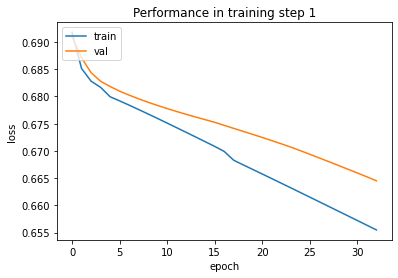

Fitting step 2
Epoch 1/33
1/1 [==============================] - 0s 154ms/step - loss: 0.6546 - binary_accuracy: 0.9091 - false_negatives_2: 11.0000 - val_loss: 0.6638 - val_binary_accuracy: 0.9091 - val_false_negatives_2: 3.0000
Epoch 2/33
1/1 [==============================] - 0s 138ms/step - loss: 0.6538 - binary_accuracy: 0.9091 - false_negatives_2: 11.0000 - val_loss: 0.6631 - val_binary_accuracy: 0.9091 - val_false_negatives_2: 3.0000
Epoch 3/33
1/1 [==============================] - 0s 127ms/step - loss: 0.6529 - binary_accuracy: 0.9091 - false_negatives_2: 11.0000 - val_loss: 0.6624 - val_binary_accuracy: 0.9091 - val_false_negatives_2: 3.0000
Epoch 4/33
1/1 [==============================] - 0s 132ms/step - loss: 0.6520 - binary_accuracy: 0.9091 - false_negatives_2: 11.0000 - val_loss: 0.6617 - val_binary_accuracy: 0.9091 - val_false_negatives_2: 3.0000
Epoch 5/33
1/1 [==============================] - 0s 129ms/step - loss: 0.6512 - binary_accuracy: 0.9091 - false_negatives_2:

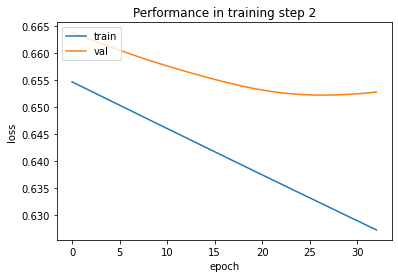

Fitting step 3
Epoch 1/33
1/1 [==============================] - 0s 161ms/step - loss: 0.6265 - binary_accuracy: 0.9091 - false_negatives_2: 11.0000 - val_loss: 0.6530 - val_binary_accuracy: 0.9091 - val_false_negatives_2: 3.0000
Epoch 2/33
1/1 [==============================] - 0s 123ms/step - loss: 0.6256 - binary_accuracy: 0.9091 - false_negatives_2: 11.0000 - val_loss: 0.6533 - val_binary_accuracy: 0.9091 - val_false_negatives_2: 3.0000
Epoch 3/33
1/1 [==============================] - 0s 135ms/step - loss: 0.6248 - binary_accuracy: 0.9091 - false_negatives_2: 11.0000 - val_loss: 0.6536 - val_binary_accuracy: 0.9091 - val_false_negatives_2: 3.0000
Epoch 4/33
1/1 [==============================] - 0s 122ms/step - loss: 0.6240 - binary_accuracy: 0.9091 - false_negatives_2: 11.0000 - val_loss: 0.6538 - val_binary_accuracy: 0.9091 - val_false_negatives_2: 3.0000
Epoch 5/33
1/1 [==============================] - 0s 124ms/step - loss: 0.6231 - binary_accuracy: 0.9091 - false_negatives_2:

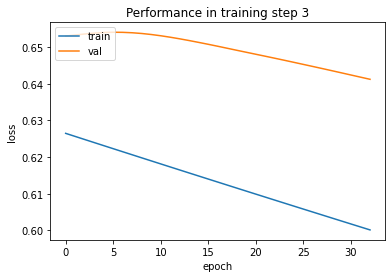

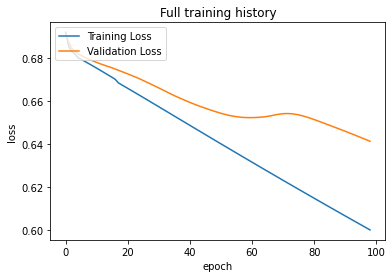

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Jun 21 15:53:58 2022

@author: joe
DEBUG TRAINING
"""

import os
from os import path as op
import tensorflow as tf
import random as rand
from PIL import Image
import numpy as np
import pandas as pd
from copy import deepcopy as dc
from matplotlib import pyplot as plt

### DEBUG
def to_colabcsv():
  ddir = get_ddir()
  outdir = op.join(ddir,"crowd_labels-improved-colab.csv")
  ddir = op.join(ddir,"crowd_labels-improved.csv")
  with open(ddir,"r") as f:
    df = pd.read_csv(f)
  newdirs = []
  for dir in df["directory"]:
    newdirs.append(dir.replace("/home/joe/local-hdd/","/content/drive/MyDrive/"))
  df["directory"] = dc(newdirs)
  with open(outdir,"w") as f:
    df.to_csv(f,line_terminator="\n",index=False,sep=",")
  return
### DEBUG END

def main():
    # Get the ResNet model
    #rn = load_rn50()
    rn = get_rn50_extended()
    # Get the training data
    train,test = get_crowdtraining(DEBUG=True)
    ### DEBUG
    # Convert the training rows into inputs and outputs for testing
    ims,outs = [],[]
    for i in range(len(train["directory"])):
        indir,out = list(train["directory"])[i],list(train["output"])[i]
        try:
          print(indir)
          ims.append(load_img(indir))
          outs.append(dc(out))
        except:
          continue
    dtrain = pd.DataFrame(data=list(zip(ims,outs)),columns=["input","output"])
    del train
    # Convert dtrain to something the model can train on
    intensorlist = [tf.convert_to_tensor(x) for x in dtrain["input"]]
    inten = tf.convert_to_tensor(intensorlist)
    del intensorlist
    outtensorlist = []
    for x in dtrain["output"]:
        y = []
        for char in x:
            try:
                y.append(int(char))
            except:
                continue
        outtensorlist.append(tf.convert_to_tensor(y,dtype=tf.int8))
    del dtrain
    outten = tf.convert_to_tensor(outtensorlist)
    test_training(rn,inten,outten,99)
    
    
    """
    # Make the base model untrainable so we can fine-tune our new layer
    rn.layers[0].trainable = False
    print("compiling")
    rn.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=1e-3),loss=tf.keras.losses.BinaryCrossentropy(),
               metrics=[tf.keras.metrics.BinaryAccuracy(),
                        tf.keras.metrics.FalseNegatives()])
    print("fitting")
    history = rn.fit(x=inten,y=outten,epochs=100,validation_split=0.2)
    plot_history(history)
    # Make the rest of the layers trainable again
    rn.layers[0].trainable=True
    """
    ### DEBUG END
    #img = debug_load_image()
    return

# Try training with the specified fraction of training the whole model vs part of it
def test_training(model,inten,outten,epochs=50,all_to_fine=0.5,order=["fine","all","fine"]):
  # Create the epoch distribution for training
  all_frac,fine_frac = all_to_fine/(1+all_to_fine),1/(1+all_to_fine)
  all_epochs,fine_epochs = int(round(all_frac*epochs)),int(round(fine_frac*epochs))
  all_epochs /= max(1,order.count("all"))
  fine_epochs /= max(1,order.count("fine"))
  training_guide = [[train_mode,{"all":int(all_epochs),"fine":int(fine_epochs)}[train_mode]] for train_mode in order]
  for i in range(len(training_guide)): training_guide[i].append(i+1)
  print(training_guide)
  # Compile the model ready for training
  totrain = dc(model)
  print("Compiling model")
  totrain.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=1e-3),loss=tf.keras.losses.BinaryCrossentropy(),
               metrics=[tf.keras.metrics.BinaryAccuracy(),
                        tf.keras.metrics.FalseNegatives()])
  full_history = []
  # Run through the training steps and train the model appropriately
  for step in training_guide:
    if(step[0]=="all"):
      totrain.layers[0].trainable = True
    elif(step[0]=="fine"):
      totrain.layers[0].trainable = False
    print(f"Fitting step {step[2]}")
    history = totrain.fit(x=inten,y=outten,epochs=step[1],validation_split=0.2)
    full_history.append(dc(history))
    plot_history(history,f"Performance in training step {step[2]}")
  plot_history_multi(full_history,title="Full training history")
  return
    

# Plot the progression of a classifier
def plot_history(history,title=""):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    if(title==""):
        plt.title('model loss')
    else:
        plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    return

# Plot multiple histories chained together
def plot_history_multi(histories,title=""):
    loss_history,val_history = [],[]
    for history in histories:
        loss_history += history.history["loss"]
        val_history += history.history["val_loss"]
    plt.plot([i for i in range(len(loss_history))],loss_history,label="Training Loss")
    plt.plot([i for i in range(len(val_history))],val_history,label="Validation Loss")
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    if(title!=""):
        plt.title(title)
    plt.show()
    return

# Convert a dataframe to an input and output list
def convert_output(df,DEBUG=False):
    ins,outs = [],[]
    adict = {'pen': 0, 'oilpaint': 1, 'watercolor': 2, 'comic': 3, 'graphite': 4, 'vectorart': 5,
             '3d': 6, 'peaceful': 7, 'happy': 8, 'gloomy': 9, 'scary': 10}
    for mid in df["mid"].unique():
        ins.append(img_id_to_dir(mid,DEBUG))
        rel = df.loc[df["mid"]==mid]
        new = [0 for i in range(len(adict))]
        for attribute in rel["attribute"]:
            new[adict[attribute]] = 1
        outs.append(np.array(new,dtype=int))
    return ins,outs

# Open the prepared crowd training data which doesn't need further modification (beyond converting directories to images)
def open_crowdtraining(DEBUG=False):
  ddir = get_ddir()
  data = pd.read_csv(os.path.join(ddir,"crowd_labels-training.csv"))
  data["output"] = data["output"].apply(lambda x: np.array(x))
  return training_split(data)

# Get a dataframe of directories to images and crowd labels
def get_crowdlabels():
    # Get directory
    ddir = anno_csv_dir()
    ddir = op.join(ddir,"crowd_labels.csv")
    # Convert to dataframe
    df = pd.read_csv(ddir)
    dirs = [img_id_to_dir(imgid) for imgid in df["mid"]]
    df["directory"] = dirs
    return df

# Get a training and testing set for images and crowd labels
def get_crowdtraining(DEBUG=False):
    # Get the improved crowd label list
    df = pd.read_csv(os.path.join(get_ddir(),"crowd_labels-improved.csv"))
    # Remove the crowdlabels with content attributes
    df = df.loc[df["attribute-type"]!="content"]
    # Refine to positive crowd labels
    df = df.loc[df["label"]=="positive"]
    # If debug is true, refine to only columns in the prototyping folder
    if(DEBUG==True):
      print(len(df))
      proto_ids = {}
      proto_dir = get_ddir();proto_dir = os.path.join(proto_dir,"images-annotated-prototyping")
      for folder in os.listdir(proto_dir):
        for filename in os.listdir(os.path.join(proto_dir,folder)):
          if(filename[0:-4] not in proto_ids):
            proto_ids[int(filename[0:-4])] = True
      df = df[df["mid"].isin(proto_ids)]
      print(len(df))
    # Convert to appropriate datatype
    ins,outs = convert_output(df,DEBUG)
    df = pd.DataFrame(data=list(zip(ins,outs)),columns=["directory","output"])
    # Split them into test and train
    return training_split(df)

# Split crowd attributes into type and specific
def split_attributes(df):
    ref = df.copy()
    # Splite attribute into attribute type and attribute
    ref.insert(1,"attribute-type",[a.split("_")[0] for a in list(ref["attribute"])].copy())
    temp = [a.split("_")[1] for a in list(ref["attribute"])].copy()
    ref["attribute"] = temp.copy()
    return ref

# Split a dataframe into training and testing
def training_split(df,train_frac=0.8,state=2183):
    train = df.sample(frac=train_frac,random_state=state)
    dfi,traini = df.index,train.index
    mask = ~dfi.isin(traini)
    return train,df.loc[mask]

# Get the directory of the csv labels folder
def anno_csv_dir():
    ddir = os.getcwd();ddir = op.dirname(ddir);ddir = op.dirname(ddir)
    ddir = op.join(ddir,"Data");ddir = op.join(ddir,"BAM");ddir = op.join(ddir,"labels-csv")
    return ddir

# Create our extended version of resnet50
# This results in 11 outputs default (for the 4 emotions and 7 media types)
def get_rn50_extended(outs=11,activator="softmax"):
    rn50 = load_rn50()
    extended = tf.keras.models.Sequential()
    extended.add(rn50)
    extended.add(tf.keras.layers.Flatten())
    try:
        extended.add(tf.keras.layers.Dense(outs,activation=activator))
    except:
        print("Unknown final layer details, defaulting to 11 softmax neurons")
        extended.add(tf.keras.layers.Dense(11,activation="softmax"))
    return extended

# Get an imagenet-trained ResNet50 model
def load_rn50():
    return tf.keras.applications.resnet50.ResNet50(
        include_top=True,
        weights='imagenet',
        input_tensor=None,
        input_shape=(224,224,3),
        pooling=None,
        classes=1000)

# Open an image from its id
def open_bamimage(imgid):
    ddir = img_id_to_dir(str(imgid))
    return load_img(ddir)

# Convert an image id to a directory
def img_id_to_dir(imgid,DEBUG=False):
    strid = imgid if type(imgid)==str else str(imgid)
    # Get the folder name from the id
    folder = strid[-4:]
    # Navigate to the data directory
    ddir = get_ddir()
    if(DEBUG==False):
      ddir = op.join(ddir,"images-annotated/images-annotated")
    else:
      ddir = op.join(ddir,"images-annotated-prototyping")
    # Get the image folder and directory
    ddir = op.join(ddir,folder)
    ddir = op.join(ddir,strid+".jpg")
    return ddir

# Predict a single image
def pred_img(img,model):
    imgtens = tf.convert_to_tensor([img],dtype=float)
    return model.predict(imgtens)
    """
    try:
        return model.predict(img)
    except:
        return model.signatures['predict'](imgtens)["probabilities"]
    """

###DEBUG###
# Open test image
def debug_load_image():
    ddir = get_bammaster_dir()
    ddir = op.join(ddir,"data");ddir = op.join(ddir,"obj");ddir = op.join(ddir,"train")
    # Get random image folder
    fold = rand.choice(os.listdir(ddir))
    ddir = op.join(ddir,fold)
    # Get a random image
    im = rand.choice(os.listdir(ddir))
    ddir = op.join(ddir,im)
    return load_img(ddir)
### DEBUG END

# Load image, taken from BAM attributions.py
def load_img(fdir,model_shape=(224,224)):
  img = Image.open(tf.io.gfile.GFile(fdir, 'rb'))
  img = preprocess_img(img,model_shape)
  return img

# Preprocessing single image; main part is resizing the image to 224x224x3
def preprocess_img(img,model_shape=(224,224),_means=[123.68, 116.78, 103.94]):
    img = img.convert('RGB').resize(model_shape, Image.BILINEAR)
    channel_means = np.expand_dims(np.expand_dims(_means, 0), 0)
    img_arr = np.array(img, dtype=np.float32) - channel_means.astype(np.float32)
    return img_arr

# Get an imagenet-trained ResNet50 model
def get_rn50():
    return tf.keras.applications.resnet50.ResNet50(
        include_top=True,
        weights='imagenet',
        input_tensor=None,
        input_shape=(224,224,3),
        pooling=None,
        classes=1000)

# Get directory to data
def get_ddir():
  return "/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/BAM"

# Load the pre-trained BAM model
def load_bam_model(choice="obj"):
    ddir = get_bammaster_dir()
    ddir = op.join(ddir,"models")
    ddir = op.join(ddir,choice)
    return tf.saved_model.load(ddir)

# Get the directory of the bam-master folder
def get_bammaster_dir():
  return "/content/drive/MyDrive/Data-Science/Art-to-fashion/Data/bam-master"

if(__name__=="__main__"): main()